torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


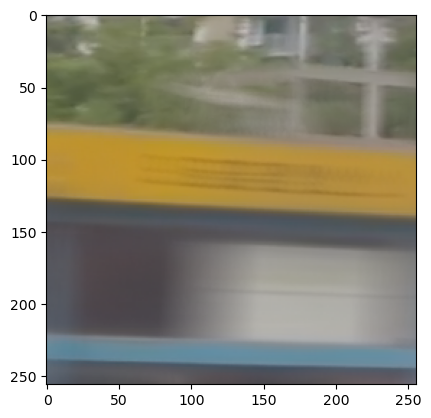

In [39]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('./deblur/low2.png')

gt = Image.open('./deblur/high2.png')
# img = Image.open('./low/146.png')
# gt = Image.open('./high/146.png')
import torchvision.transforms as transforms
transform = transforms.ToTensor()
x = transform(img)
gt = transform(gt)

x = x.unsqueeze(0)
x_input = x
print(x.shape)
print(gt.shape)
plt.imshow(x[0].permute(1,2,0).numpy())

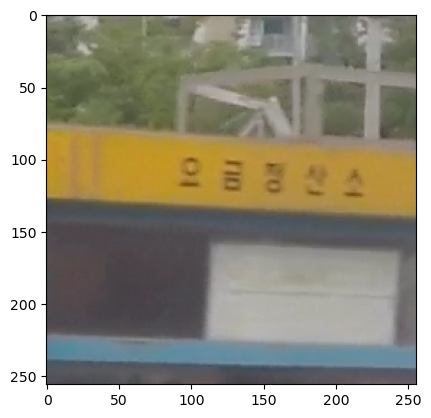

In [188]:
plt.imshow(gt.permute(1,2,0).numpy())

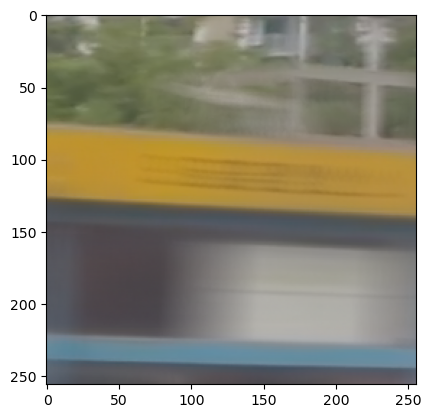

In [214]:
import torch
import torch.nn as nn
_, _, H, W = x.shape
y = torch.fft.rfft2(x, norm='backward')
y_imag = y.imag #(N, nf, H, W/2 + 1)
y_real = y.real #(N, nf, H, W/2 + 1)

y_f = torch.cat([y_real, y_imag], dim=3) #(N, 2 * nf, H, W/2 + 1)
# y = self.main_fft(y_f) #(N, 2 * nf, H, W/2 + 1)
y_real, y_imag = torch.chunk(y_f, 2, dim=3) #(N, nf, H, W/2 + 1) * 2
y = torch.complex(y_real, y_imag) #(N, nf, H, W/2 + 1)
y_fft = torch.fft.irfft2(y, s=(H, W), norm='backward')
plt.imshow(y_fft[0].permute(1,2,0).numpy())

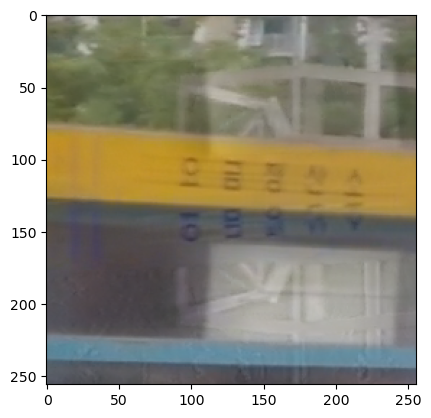

In [215]:
import torch.nn.functional as F
_, H, W = gt.shape
x_fft = torch.fft.fft2(x , dim = 2,  norm = 'backward')
x_mag = torch.abs(x_fft)
x_pha = torch.angle(x_fft)
x_r = x_mag * torch.cos(x_pha)
x_i = x_mag * torch.sin(x_pha)

x_r_fft = torch.fft.fft2(x_r, dim = 2, norm = 'backward')
x_r_mag = torch.abs(x_r_fft)
x_r_pha = torch.angle(x_r_fft)
x_r_r = x_r_mag * torch.cos(x_r_pha)
x_r_i = x_r_mag * torch.sin(x_r_pha)

gt_fft = torch.fft.fft2(gt.unsqueeze(0) ,dim = 2,  norm = 'backward')
gt_mag = torch.abs(gt_fft)
gt_pha = torch.angle(gt_fft)
gt_r = gt_mag * torch.cos(gt_pha)
gt_i = gt_mag * torch.sin(gt_pha)

gt_r_fft = torch.fft.fft2(gt_r,dim = 2, norm = 'backward')
gt_r_mag = torch.abs(gt_r_fft)
gt_r_pha = torch.angle(gt_r_fft)
gt_r_r = gt_r_mag * torch.cos(gt_r_pha)
gt_r_i = gt_r_mag * torch.sin(gt_r_pha)

e = torch.randn_like(x_r_r)
# 这里交换的是real，不是mag
pred_r = torch.fft.ifft2(torch.complex(gt_r_r, x_r_i), dim = 2, norm = 'backward').real

pred_x = torch.fft.ifft2(torch.complex(pred_r, x_i), dim = 2, norm = 'backward').real

plt.imshow((pred_x[0]).permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


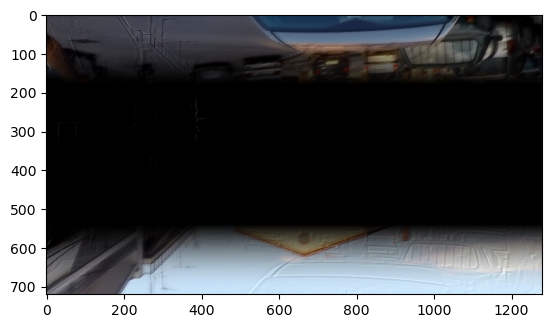

In [37]:
v2 = transforms.Compose([
            transforms.RandomHorizontalFlip(p=1.),
        ])
v1 = transforms.Compose([
            transforms.RandomVerticalFlip(p=1.),
        ])

v3 = transforms.Compose([
            transforms.RandomHorizontalFlip(p=1.),
            transforms.RandomVerticalFlip(p=1.),
        ])
mix = torch.fft.ifft2(torch.complex(v1(gt_r), v1(x_i)),dim=2, norm = 'backward').real
plt.imshow(mix[0].permute(1,2,0).numpy())

# only swap amplitude is not enough

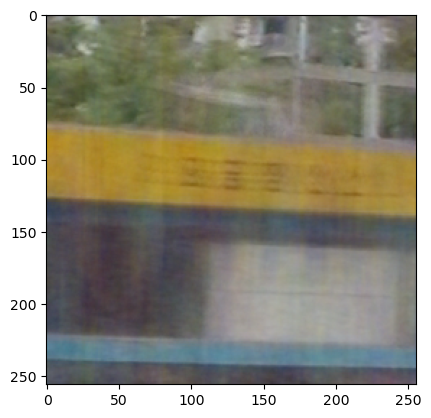

In [229]:
_, _, h, w = x.shape
x_fft = torch.fft.fft2(x, s=(h,w), norm = 'backward')
x_mag = torch.abs(x_fft)
x_pha = torch.angle(x_fft)

gt_fft = torch.fft.fft2(gt.unsqueeze(0),  s=(h,w), norm = 'backward')
gt_mag = torch.abs(gt_fft)
gt_pha = torch.angle(gt_fft)

mix_r = gt_mag * torch.cos(x_pha)
mix_i = gt_mag * torch.sin(x_pha)

mix = torch.fft.ifft2(torch.complex(mix_r, mix_i), s=(h,w), norm = 'backward').real
plt.imshow(torch.sin(mix)[0].permute(1,2,0).numpy())

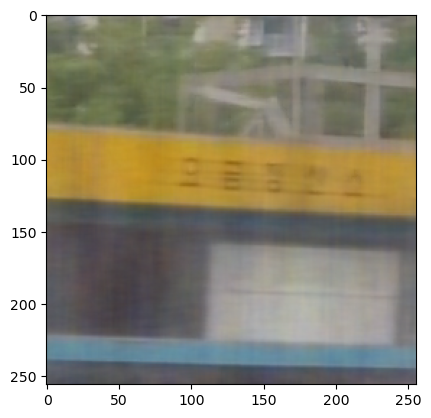

In [230]:
mix_r = x_mag * torch.cos(gt_pha)
mix_i = x_mag * torch.sin(gt_pha)

mix = torch.fft.ifft2(torch.complex(mix_r, mix_i), s=(h,w), norm = 'backward').real
plt.imshow(mix[0].permute(1,2,0).numpy())

# Use AmpNet

In [49]:
import torch
import torch.nn as nn


class SpaBlock(nn.Module):
    def __init__(self, nc):
        super(SpaBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(nc,nc,3,1,1),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(nc, nc, 3, 1, 1),
            nn.LeakyReLU(0.1, inplace=True))

    def forward(self, x):
        return x+self.block(x)

class FreBlock(nn.Module):
    def __init__(self, nc):
        super(FreBlock, self).__init__()
        self.fpre = nn.Conv2d(nc, nc, 1, 1, 0)
        self.process1 = nn.Sequential(
            nn.Conv2d(nc, nc, 1, 1, 0),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(nc, nc, 1, 1, 0))
        self.process2 = nn.Sequential(
            nn.Conv2d(nc, nc, 1, 1, 0),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(nc, nc, 1, 1, 0))

    def forward(self, x):
        _, _, H, W = x.shape
        x_freq = torch.fft.rfft2(self.fpre(x), norm='backward')
        mag = torch.abs(x_freq)
        pha = torch.angle(x_freq)
        mag = self.process1(mag)
        pha = self.process2(pha)
        real = mag * torch.cos(pha)
        imag = mag * torch.sin(pha)
        x_out = torch.complex(real, imag)
        x_out = torch.fft.irfft2(x_out, s=(H, W), norm='backward')

        return x_out+x

class ProcessBlock(nn.Module):
    def __init__(self, in_nc, spatial = True):
        super(ProcessBlock,self).__init__()
        self.spatial = spatial
        self.spatial_process = SpaBlock(in_nc) if spatial else nn.Identity()
        self.frequency_process = FreBlock(in_nc)
        self.cat = nn.Conv2d(2*in_nc,in_nc,1,1,0) if spatial else nn.Conv2d(in_nc,in_nc,1,1,0)

    def forward(self, x):
        xori = x
        x_freq = self.frequency_process(x)
        x_spatial = self.spatial_process(x)
        xcat = torch.cat([x_spatial,x_freq],1)
        x_out = self.cat(xcat) if self.spatial else self.cat(x_freq)

        return x_out+xori

class SFNet(nn.Module):

    def __init__(self, nc,n=1):
        super(SFNet,self).__init__()

        self.conv1 = ProcessBlock(nc,spatial=False)
        self.conv2 = ProcessBlock(nc,spatial=False)
        self.conv3 = ProcessBlock(nc,spatial=False)
        self.conv4 = ProcessBlock(nc,spatial=False)
        self.conv5 = ProcessBlock(nc,spatial=False)

    def forward(self, x):
        x_ori = x
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        xout = x_ori + x5
        return xout

class AmplitudeNet_skip(nn.Module):
    def __init__(self, nc,n=1):
        super(AmplitudeNet_skip,self).__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(3, nc, 1, 1, 0),
            ProcessBlock(nc),
        )
        self.conv1 = ProcessBlock(nc)
        self.conv2 = ProcessBlock(nc)
        self.conv3 = ProcessBlock(nc)
        self.conv4 = nn.Sequential(
            ProcessBlock(nc * 2),
            nn.Conv2d(nc * 2, nc, 1, 1, 0),
        )
        self.conv5 = nn.Sequential(
            ProcessBlock(nc * 2),
            nn.Conv2d(nc * 2, nc, 1, 1, 0),
        )
        self.convout = nn.Sequential(
            ProcessBlock(nc * 2),
            nn.Conv2d(nc * 2, 3, 1, 1, 0),
        )

    def forward(self, x):

        x = self.conv0(x)
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(torch.cat((x2, x3), dim=1))
        x5 = self.conv5(torch.cat((x1, x4), dim=1))
        xout = self.convout(torch.cat((x, x5), dim=1))

        return xout


In [54]:
AmpNet = nn.Sequential(
            AmplitudeNet_skip(8),
            nn.Sigmoid()
        )
curve_maps = AmpNet(gt.unsqueeze(0))

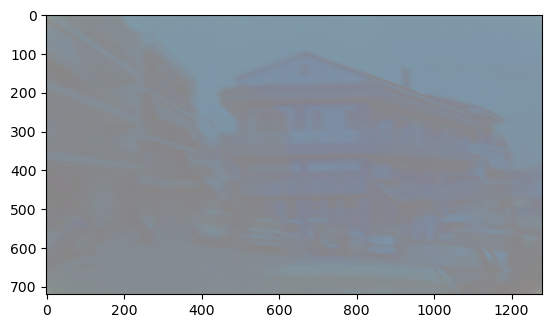

In [78]:
plt.imshow(curve_maps[0].permute(1,2,0).detach().numpy())

# swapping amp and pha

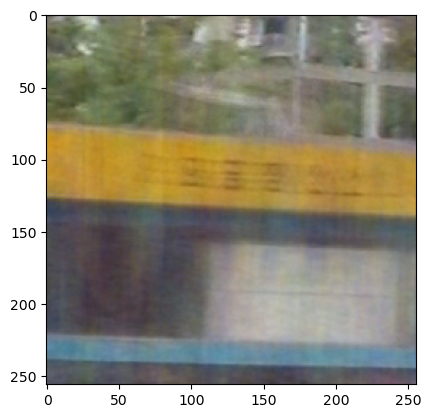

In [231]:
# gt_mag = gt_mag / (curve_maps + 0.00000001)
mix_r = gt_mag * torch.cos(x_pha)
mix_i = gt_mag * torch.sin(x_pha)

gm_xp = torch.fft.ifft2(torch.complex(mix_r, mix_i), dim=(-1, -2)).real
plt.imshow(gm_xp[0].permute(1,2,0).detach().numpy()) # 这个增强网络应该是调亮度用的

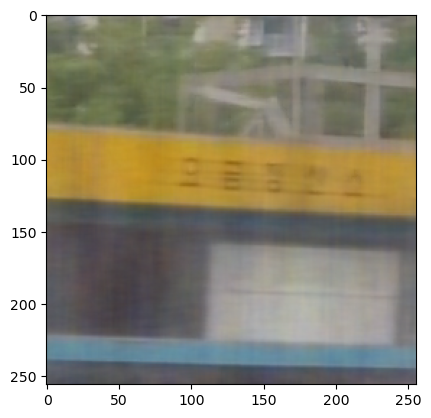

In [232]:
mix_r = x_mag * torch.cos(gt_pha)
mix_i = x_mag * torch.sin(gt_pha)
xm_gp = torch.fft.ifft2(torch.complex(mix_r, mix_i), dim=(-1, -2)).real
plt.imshow(xm_gp[0].permute(1,2,0).detach().numpy())

In [233]:
psnr = metrics.peak_signal_noise_ratio(torch.sin(xm_gp[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy())
ssim = metrics.structural_similarity(torch.sin(xm_gp[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy(), multichannel=True)
print("xm_gp with GT:", [psnr, ssim])

xm_gp with GT: [27.45813087284841, 0.9576321]


/tmp/ipykernel_1300174/330821144.py:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = metrics.structural_similarity(torch.sin(xm_gp[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy(), multichannel=True)


In [234]:
psnr = metrics.peak_signal_noise_ratio(torch.sin(gm_xp[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy())
ssim = metrics.structural_similarity(torch.sin(gm_xp[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy(), multichannel=True)
print("gm_xp with GT:", [psnr, ssim])

gm_xp with GT: [27.37916304933082, 0.9350335]


/tmp/ipykernel_1300174/1948322001.py:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = metrics.structural_similarity(torch.sin(gm_xp[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy(), multichannel=True)


In [197]:
xr_gi = torch.fft.ifft2(torch.complex(x_fft.real, gt_fft.imag), dim=-1).real
gr_xi = torch.fft.ifft2(torch.complex(gt_fft.real, x_fft.imag), dim=-1).real

In [198]:
psnr = metrics.peak_signal_noise_ratio(torch.sin(gr_xi[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy())
ssim = metrics.structural_similarity(torch.sin(gr_xi[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy(), multichannel=True)
print("xm_gp with GT:", [psnr, ssim])

xm_gp with GT: [28.489125744440496, 0.9643598]


/tmp/ipykernel_1300174/2152125103.py:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = metrics.structural_similarity(torch.sin(gr_xi[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy(), multichannel=True)


# low and high freq

In [199]:
from pytorch_wavelets import DWT1DForward, DWT1DInverse, DWTForward, DWTInverse, DTCWTForward, DTCWTInverse
import torch.nn as nn
dwt = DWTForward(J=1, mode = 'zero', wave='haar')
# dwt = pywt.dwt2(x, 'haar', 'zero')
iwt = DWTInverse(mode='zero')

In [200]:
gt_low, gt_high = dwt(gt.unsqueeze(0))
x_low, x_high = dwt(x)

In [145]:
x_h = x_high[0][0][0] + x_high[0][0][1] + x_high[0][0][2]

In [201]:
gt_x = iwt([gt_low, x_high])
x_gt = iwt([x_low, gt_high])

In [236]:
from skimage import io, metrics, exposure
psnr = metrics.peak_signal_noise_ratio(torch.sin(gt_x[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy())
ssim = metrics.structural_similarity(torch.sin(gt_x[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy(), multichannel=True)
print("gt_x with GT:", [psnr, ssim])

gt_x with GT: [30.78720650673858, 0.9871478]


/tmp/ipykernel_1300174/2912073077.py:3: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = metrics.structural_similarity(torch.sin(gt_x[0]).permute(1,2,0).numpy(), gt.permute(1,2,0).numpy(), multichannel=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


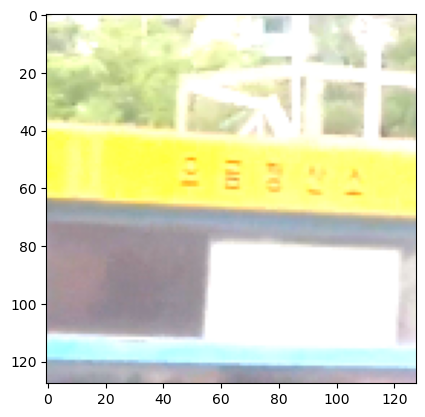

In [205]:
plt.imshow(gt_low[0].permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


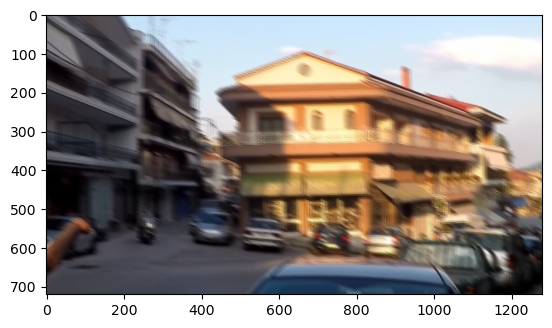

In [135]:
plt.imshow(x_gt[0].permute(1,2,0).numpy())

# use shift

In [225]:
x_shift = torch.fft.fftshift(x_fft)
x_mag = torch.abs(x_shift)
x_pha = torch.angle(x_shift)

gt_shift = torch.fft.fftshift(gt_fft)
gt_mag = torch.abs(gt_shift)
gt_pha = torch.angle(gt_shift)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


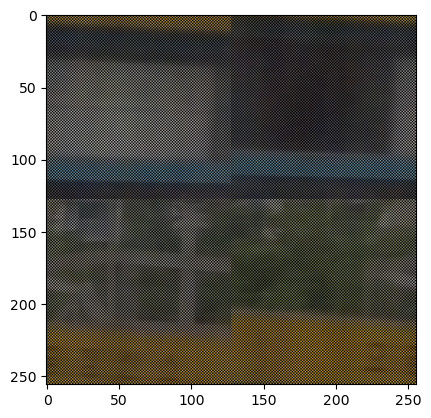

In [228]:
mix_r = x_mag * torch.cos(gt_pha)
mix_i = x_mag * torch.sin(gt_pha)
xm_gp = torch.fft.ifft2(torch.complex(mix_r, mix_i), dim=(-1, -2))
xm_gp = torch.fft.ifftshift(xm_gp).real
plt.imshow(xm_gp[0].permute(1,2,0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


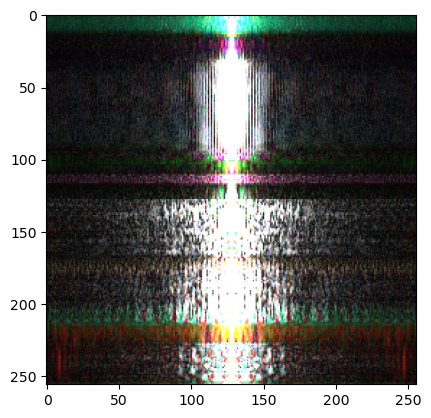

In [213]:
plt.imshow(gt_mag[0].permute(1,2,0).numpy())

# 降维画图 可视化

In [90]:
def window_partitions(x, window_size):
    """
    Args:
        x: (B, C, H, W)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, C, window_size, window_size)
    """
    B, C, H, W = x.shape
    x = x.view(B, C, H // window_size, window_size, W // window_size, window_size)
    windows = x.permute(0, 2, 4, 1, 3, 5).contiguous().view(-1, C, window_size, window_size)
    return windows


def window_reverses(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, C, window_size, window_size)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, C, H, W)
    """
    # B = int(windows.shape[0] / (H * W / window_size / window_size))
    # print('B: ', B)
    # print(H // window_size)
    # print(W // window_size)
    C = windows.shape[1]
    # print('C: ', C)
    x = windows.view(-1, H // window_size, W // window_size, C, window_size, window_size)
    x = x.permute(0, 3, 1, 4, 2, 5).contiguous().view(-1, C, H, W)
    return x
def window_partitionx(x, window_size):
    _, _, H, W = x.shape
    h, w = window_size * (H // window_size), window_size * (W // window_size)
    x_main = window_partitions(x[:, :, :h, :w], window_size)
    b_main = x_main.shape[0]
    if h == H and w == W:
        return x_main, [b_main]
    if h != H and w != W:
        x_r = window_partitions(x[:, :, :h, -window_size:], window_size)
        b_r = x_r.shape[0] + b_main
        x_d = window_partitions(x[:, :, -window_size:, :w], window_size)
        b_d = x_d.shape[0] + b_r
        x_dd = x[:, :, -window_size:, -window_size:]
        b_dd = x_dd.shape[0] + b_d
        # batch_list = [b_main, b_r, b_d, b_dd]
        return torch.cat([x_main, x_r, x_d, x_dd], dim=0), [b_main, b_r, b_d, b_dd]
    if h == H and w != W:
        x_r = window_partitions(x[:, :, :h, -window_size:], window_size)
        b_r = x_r.shape[0] + b_main
        return torch.cat([x_main, x_r], dim=0), [b_main, b_r]
    if h != H and w == W:
        x_d = window_partitions(x[:, :, -window_size:, :w], window_size)
        b_d = x_d.shape[0] + b_main
        return torch.cat([x_main, x_d], dim=0), [b_main, b_d]

In [84]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.manifold import TSNE
tsne_2D = TSNE(n_components=2, init='pca', random_state=0)


In [169]:
x_tsne = window_partitionx(x, 64)[0].permute(1,0,2,3)
# x_tsne = x_tsne[0]
print(x_tsne.shape)
print(x.shape)
# x_tsne.reshape(len(x_tsne), -1).shape

torch.Size([3, 240, 64, 64])
torch.Size([1, 3, 720, 1280])


In [99]:
result_2D = tsne_2D.fit_transform(x_tsne.reshape(len(x_tsne), -1))

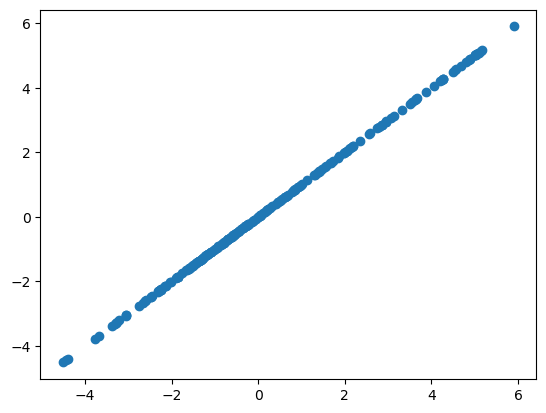

In [100]:
plt.scatter(result_2D[:, 0], result_2D[:, 0])

In [112]:
import numpy as np
x_fft = np.fft.fft2(x[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


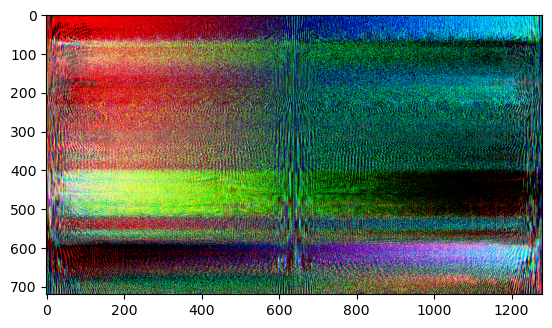

In [122]:
plt.imshow(np.sin(np.angle(x_fft)))

array([[[ 0.        ,  0.46771515, -0.46771515],
        [ 0.53054935, -0.66576485,  0.02319346],
        [ 0.83683595, -0.93979392, -0.54135803],
        ...,
        [-0.99492946,  0.90394254,  0.97869293],
        [-0.83683595,  0.54135803,  0.93979392],
        [-0.53054935, -0.02319346,  0.66576485]],

       [[ 0.        ,  0.46784598, -0.46784598],
        [ 0.53210166, -0.66643393,  0.02560529],
        [ 0.83902972, -0.9396915 , -0.54124949],
        ...,
        [-0.99551905,  0.90275546,  0.97793809],
        [-0.83902972,  0.54124949,  0.9396915 ],
        [-0.53210166, -0.02560529,  0.66643393]],

       [[ 0.        ,  0.46765232, -0.46765232],
        [ 0.53391285, -0.66626078,  0.02376489],
        [ 0.84229917, -0.94190573, -0.5447188 ],
        ...,
        [-0.99621774,  0.90589042,  0.97574681],
        [-0.84229917,  0.5447188 ,  0.94190573],
        [-0.53391285, -0.02376489,  0.66626078]],

       ...,

       [[ 0.        ,  0.55283924, -0.55283924],
        [-0

In [173]:
x_fft = torch.fft.fft2(x)
torch.abs(x_fft)

tensor([[[[462415.7812,  96039.0938,  31993.0000,  ...,  33563.1992,
            31992.9980,  96039.0938],
          [ 82451.5703,  12848.2520,   5236.9766,  ...,  13458.3799,
            40325.8906,  29083.9434],
          [ 40671.5547,  14809.9678,  14959.8027,  ...,   4805.0659,
            13668.0352,  16024.9727],
          ...,
          [ 33572.9297,   9362.4277,   1944.5635,  ...,   3675.8347,
             2442.8569,  12726.8340],
          [ 40671.5547,  16024.9736,  13668.0361,  ...,  10586.6445,
            14959.8018,  14809.9658],
          [ 82451.5703,  29083.9453,  40325.8945,  ...,  22870.2676,
             5236.9766,  12848.2529]],

         [[425532.7812,  73524.5781,  37248.5352,  ...,  32014.5371,
            37248.5352,  73524.5781],
          [ 96897.2031,   2704.7341,   3465.3655,  ...,  13801.2285,
            43913.0664,  16442.9199],
          [ 47236.5000,   6228.8633,  17671.5918,  ...,   4723.5605,
            13643.9502,  21879.2520],
          ...,
     

In [182]:
x_norm = x_mag/torch.max(x_mag)
real = x_norm * torch.cos(x_pha)
imag = x_norm * torch.sin(x_pha)
x_res = torch.fft.ifft2(torch.complex(real, imag), dim=-1, norm = 'backward').real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


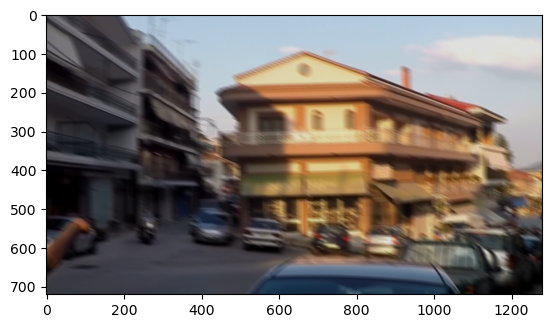

In [185]:
plt.imshow((1000*x_res)[0].permute(1,2,0).numpy())

In [184]:
x_res

tensor([[[[0.0004, 0.0004, 0.0004,  ..., 0.0007, 0.0007, 0.0007],
          [0.0004, 0.0004, 0.0004,  ..., 0.0007, 0.0007, 0.0007],
          [0.0004, 0.0004, 0.0004,  ..., 0.0007, 0.0007, 0.0007],
          ...,
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],

         [[0.0004, 0.0004, 0.0004,  ..., 0.0008, 0.0008, 0.0008],
          [0.0004, 0.0004, 0.0004,  ..., 0.0008, 0.0008, 0.0008],
          [0.0004, 0.0004, 0.0004,  ..., 0.0008, 0.0008, 0.0008],
          ...,
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],

         [[0.0004, 0.0004, 0.0004,  ..., 0.0009, 0.0009, 0.0009],
          [0.0004, 0.0004, 0.0004,  ..., 0.0009, 0.0009, 0.0009],
          [0.0004, 0.0004, 0.0004,  ..., 0

In [186]:
x_pha.shape

torch.Size([1, 3, 720, 1280])

# Learnable Filter

In [3]:
import torch.nn as nn
class DF(nn.Module):
    '''Frequency-Hierarchy module'''

    def __init__(self, channel_num):
        super(DF, self).__init__()

        self.C0 = nn.Sequential(
             nn.Conv2d(channel_num, channel_num//3, groups=channel_num//3, kernel_size=3, stride=1, padding=1),
             nn.LeakyReLU(inplace=True))
             
        self.C1 = nn.Sequential(
             nn.Conv2d(channel_num, channel_num//3, groups=channel_num//3, kernel_size=3, stride=1, padding=2, dilation = 2),
             nn.LeakyReLU(inplace=True))    

        self.C2 = nn.Sequential(
             nn.Conv2d(channel_num, channel_num//3, groups=channel_num//3, kernel_size=3, stride=1, padding=3, dilation = 3),
             nn.LeakyReLU(inplace=True))

        self.R = nn.GELU()

    def forward(self, x):
        l = self.R(self.C2(x))
        m = self.R(self.C1(x) - l)
        h = self.R(self.C0(x) - self.C1(x))
        return l, m, h   

In [4]:
df = DF(3)
l, m, h = df(x)

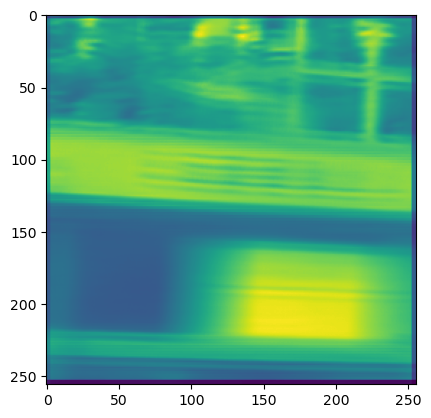

In [5]:
plt.imshow(l[0].permute(1,2,0).detach().numpy())

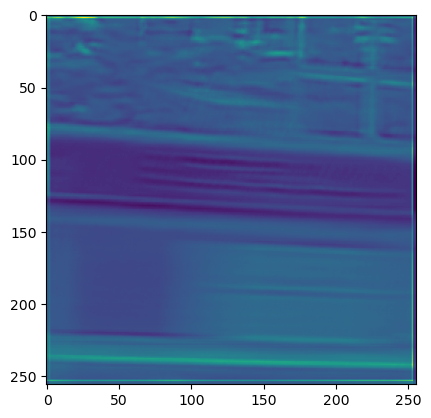

In [6]:
plt.imshow(m[0].permute(1,2,0).detach().numpy())

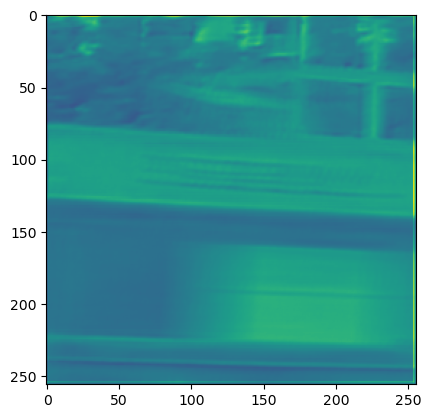

In [7]:
plt.imshow(h[0].permute(1,2,0).detach().numpy())

In [8]:
l, m, h = df(gt)

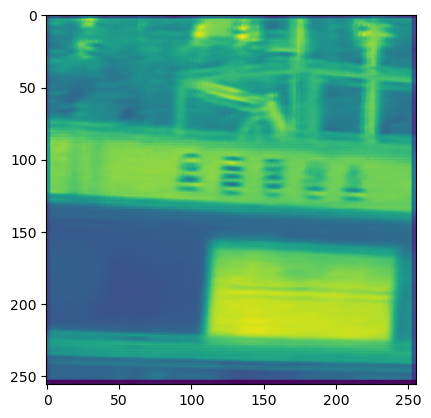

In [11]:
plt.imshow(l.permute(1,2,0).detach().numpy())

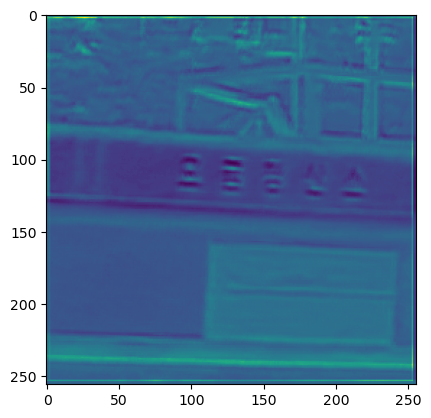

In [12]:
plt.imshow(m.permute(1,2,0).detach().numpy())

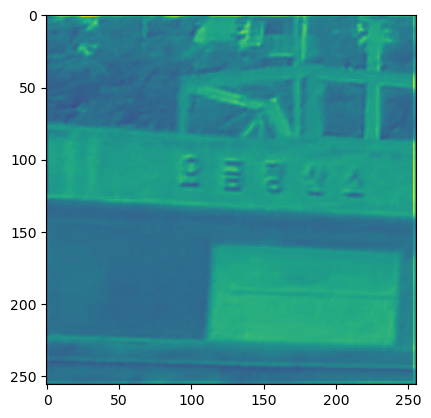

In [13]:
plt.imshow(h.permute(1,2,0).detach().numpy())

In [11]:
import torch.nn as nn
import torch
import torch.nn.functional as F
class dynamic_filter(nn.Module):
    def __init__(self, inchannels, kernel_size=3, stride=1, group=6):
        super(dynamic_filter, self).__init__()
        self.stride = stride
        self.kernel_size = kernel_size
        self.group = group

        self.lamb_l = nn.Parameter(torch.zeros(inchannels), requires_grad=True)
        self.lamb_h = nn.Parameter(torch.zeros(inchannels), requires_grad=True)

        self.conv = nn.Conv2d(inchannels, group*kernel_size**2, kernel_size=1, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(group*kernel_size**2)
        self.act = nn.Softmax(dim=-2)
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')

        self.pad = nn.ReflectionPad2d(kernel_size//2)

        self.ap = nn.AdaptiveAvgPool2d((1, 1))
#         self.modulate = SFconv(inchannels)

    def forward(self, x):
        identity_input = x 
        low_filter = self.ap(x)
        low_filter = self.conv(low_filter)
        low_filter = self.bn(low_filter)     

        n, c, h, w = x.shape  
        x = F.unfold(self.pad(x), kernel_size=self.kernel_size).reshape(n, self.group, c//self.group, self.kernel_size**2, h*w)

        n,c1,p,q = low_filter.shape
        low_filter = low_filter.reshape(n, c1//self.kernel_size**2, self.kernel_size**2, p*q).unsqueeze(2)
       
        low_filter = self.act(low_filter)
    
        low_part = torch.sum(x * low_filter, dim=3).reshape(n, c, h, w)

        out_high = identity_input - low_part
#         out = self.modulate(low_part, out_high)
        return low_part, out_high

In [12]:
dfilter = dynamic_filter(inchannels = 3, kernel_size = 1)

In [24]:
avg_pool = nn.AdaptiveAvgPool2d((1, 1))
conv_du = nn.Sequential(
            nn.Conv2d(3, 12, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 3, 1, padding=0, bias=True),
            nn.Sigmoid())


In [25]:
out = x * conv_du(avg_pool(x))
out.shape

torch.Size([1, 3, 256, 256])

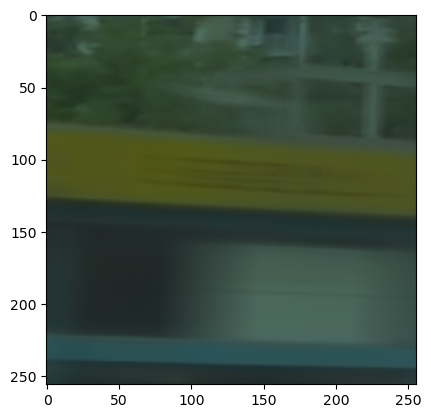

In [27]:
plt.imshow((x-out)[0].permute(1,2,0).detach().numpy())

In [34]:
conv = nn.Conv2d(3, 3, kernel_size = 3, stride = 4, bias = False)
test = torch.randn(1,3,64,64)
conv(test).shape

torch.Size([1, 3, 16, 16])

# NMF 分解


In [38]:
from torchnmf.nmf import NMF2D 

In [71]:
R = 1
T= 100
x_nmf = x.permute(2,3,0,1)
net = NMF2D(x_nmf.shape, rank = 2).cuda()
net.fit(x_nmf.cuda())

80

In [74]:
V = net()
W, H = net.W.detach(), net.H.detach()
print(W.shape, H.shape)


torch.Size([256, 2, 1, 1]) torch.Size([256, 2, 1, 3])


In [86]:
result = torch.einsum('klij,mlij->kmij', W, H)


torch.Size([256, 256, 1, 3])

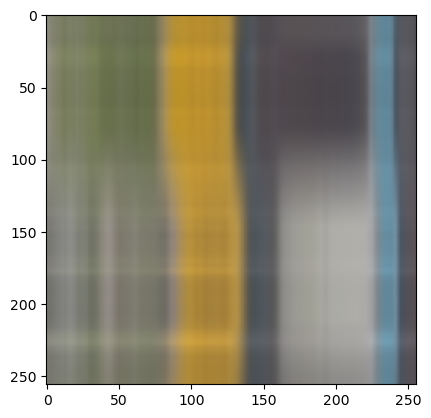

In [89]:
plt.imshow(result.squeeze(2).detach().cpu().numpy())

In [59]:
import torch_dct as dct
X = dct.dct_2d(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


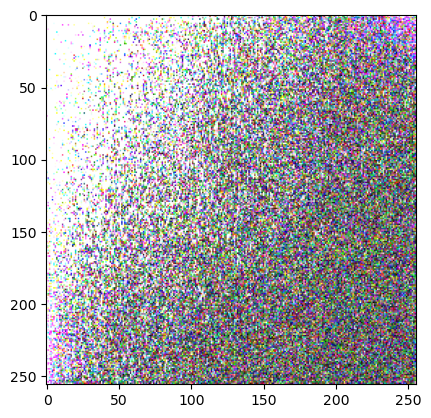

In [60]:
output_dct = torch.log(torch.abs(X[0]) + 1)
plt.imshow(output_dct.permute(1,2,0))

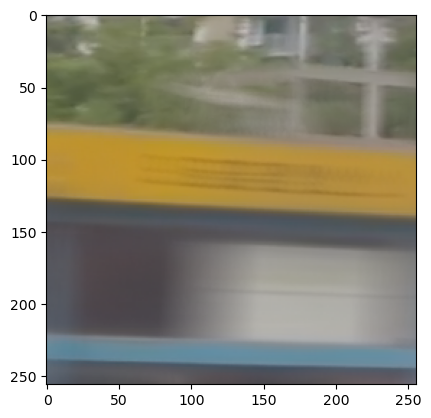

In [61]:
plt.imshow(x[0].permute(1,2,0))

In [ ]:
W, H = NMF2D(x, 2, init = 'random')